In [13]:
%%capture

!pip install shap lime

In [14]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import root_mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_blobs

from xgboost import XGBRegressor

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import shap
from lime import lime_tabular

import warnings
warnings.simplefilter('ignore')

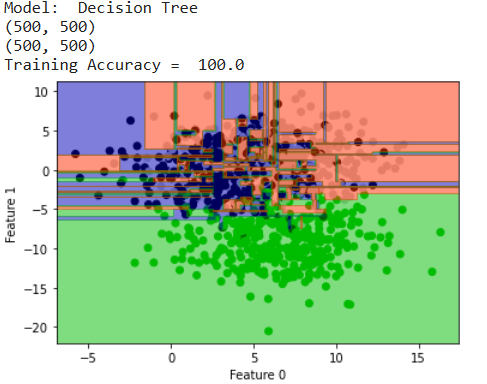

## Ансамблирование моделей

Техника для улучшения качества предсказаний. Основная идея заключается в том, что отдельно обучаются несколько моделей, а далее их предсказания комбинируются.

**Почему это работает?**

Основной принцип - создать максимально разнообразный ансамбль, чтобы ошибки одних алгоритмов на отдельных объектах будут компенсировались корректной работой других алгоритмов

### Подготовка данных + LinearRegression

In [15]:
data = pd.read_csv('abalone.data.txt', header=None)
data.columns = ['sex', 'length', 'diameter', 'height', 'whole_weight', 'hucked_weight', 'viscera_weight', 'shell_weight', 'rings']
data.head()

sex  length  diameter  height  whole_weight  hucked_weight  viscera_weight  \
0   M   0.455     0.365   0.095        0.5140         0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255         0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770         0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160         0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050         0.0895          0.0395   

   shell_weight  rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7

In [16]:
res = pd.get_dummies(data['sex'], prefix='sex', drop_first=True)
data = pd.concat([data, res], axis=1).drop(columns='sex')

In [17]:
corrs = data.corr()
upper_tri = corrs.where(np.triu(np.ones(corrs.shape), k=1).astype(np.bool_))
cols_to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
cutted_data = data.drop(columns=cols_to_drop)
cutted_data.head()

length  height  whole_weight  rings  sex_I  sex_M
0   0.455   0.095        0.5140     15  False   True
1   0.350   0.090        0.2255      7  False   True
2   0.530   0.135        0.6770      9  False  False
3   0.440   0.125        0.5160     10  False   True
4   0.330   0.080        0.2050      7   True  False

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    cutted_data.drop(columns='rings'),
    cutted_data['rings'],
    random_state=2023,
    test_size=0.3
)

In [19]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

In [20]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_preds_lr = lr.predict(X_test_scaled)

In [21]:
print(f'RMSE: {root_mean_squared_error(y_test, y_preds_lr)}')

RMSE: 2.5041378689818625


### Простое усреднение

In [22]:
models = [LinearRegression(), Ridge(), KNeighborsRegressor()]
preds = []
for model in models:
  model.fit(X_train_scaled, y_train)
  preds.append(model.predict(X_test_scaled))
y_preds = np.array(preds).mean(axis=0)
print(f'RMSE: {root_mean_squared_error(y_test, y_preds)}')

RMSE: 2.4803732019250906


### Бэггинг

**Bagging (Bootstrap aggregating)**






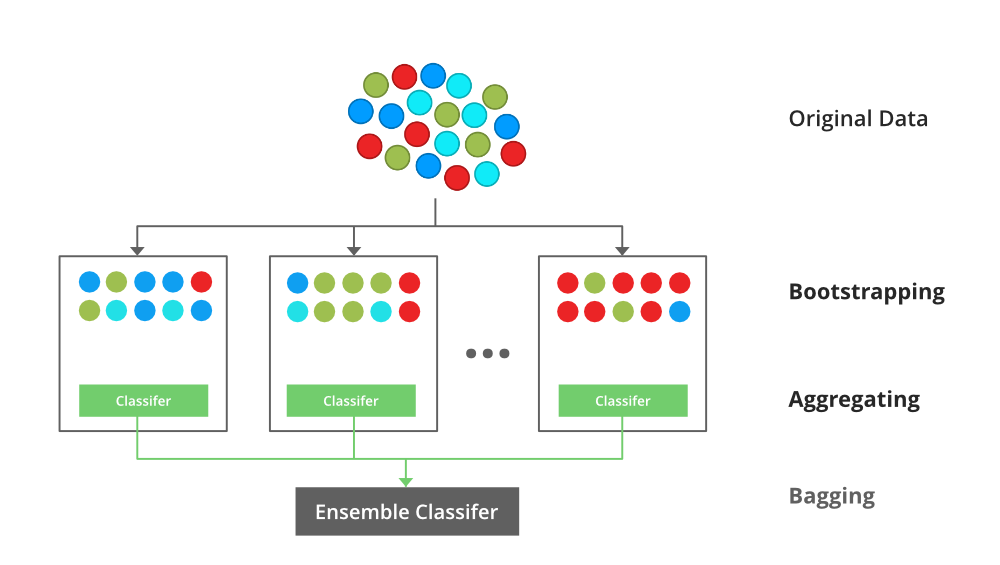

#### Bias-Variance trade-off

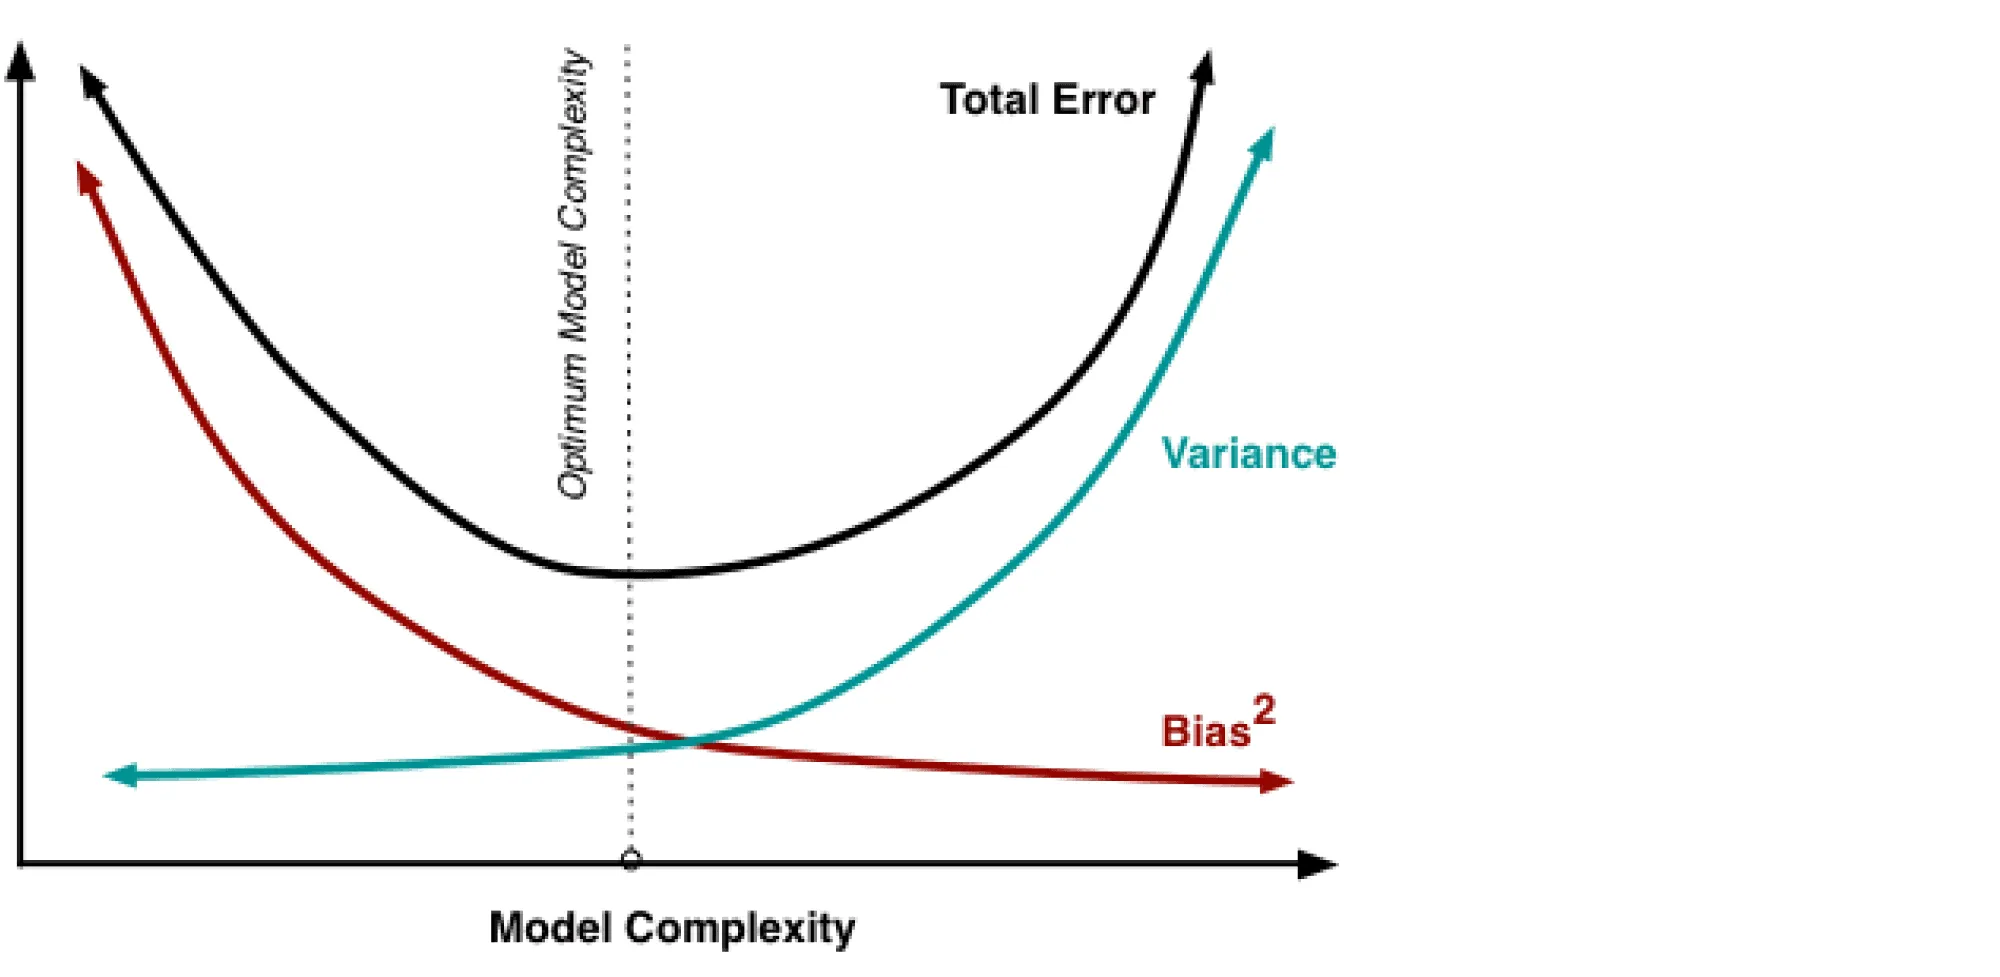

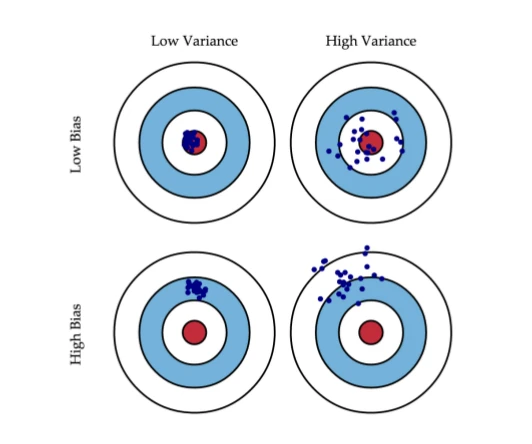

Если k базовых алгоритмов некоррелированы, то можно показать, что дисперсия композиции в k раз меньше дисперсии отдельного алгоритма

#### BaggingRegressor

In [23]:
bagging_model = BaggingRegressor(
    estimator=LinearRegression(),
    n_estimators=10,
    random_state=2023,
).fit(X_train_scaled, y_train)
y_preds = bagging_model.predict(X_test_scaled)
print(f'RMSE: {root_mean_squared_error(y_test, y_preds)}')

RMSE: 2.482443526341356


#### Случайный лес

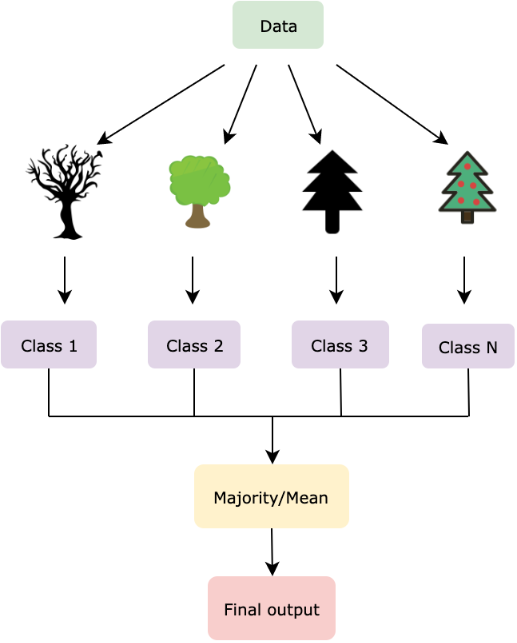

Итого:

- Выбирается подвыборка обучающей выборки размера samplesize – по ней строится дерево (для каждого дерева — своя подвыборка).
- Для построения каждого расщепления в дереве просматриваем max_features случайных признаков (для каждого нового расщепления — свои случайные признаки).
- Выбираем наилучшие признак и расщепление по нему.
- Дерево строится, как правило, до исчерпания выборки (но можно ограничить `max_depth`),




In [24]:
rf = RandomForestRegressor(random_state=2023)
rf.fit(X_train, y_train)
y_preds = rf.predict(X_test)
print(f'RMSE: {root_mean_squared_error(y_test, y_preds)}')

RMSE: 2.6341285589993437


In [25]:
parameters = {
    'n_estimators': np.arange(50, 160, 20),
    'max_depth': list(range(3, 11)) + [None],
    'random_state': [2023],
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=2023),
    param_grid=parameters,
    n_jobs=2,
    verbose=1,
    cv=3,
)

In [26]:
%%time

grid_search.fit(X_train, y_train)

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits
max_depth: 5
n_estimators: 130
random_state: 2023
CPU times: user 2.36 s, sys: 324 ms, total: 2.69 s
Wall time: 1min 32s


In [27]:
y_preds = grid_search.best_estimator_.predict(X_test)
print(f'RMSE: {root_mean_squared_error(y_test, y_preds)}')

RMSE: 2.4356039867221533


##### Настройка некоторых гиперпараметров

- Лучший способ определить оптимальное количество деревьев (`n_estimators`) - попробовать разные варианты, со временем качество на valid выборке выйдет на плато
- Для `max_features` есть пространтсов для экспериментов. Эмпирические оценки говорят, что для классификации оптимальные варианты - $0.5 * \sqrt{M}$ или $\sqrt{M}$, или $2 * \sqrt{M}$. Для регрессии $0.5 * (M/3)$ или $M/3$, или $2 * (M/3)$
- В целом RF не так чувствителен к большим/неограниченным значениям `max_depth`, но при высокой доле шума в данных построение деревьев до исчерпания выборки не дает хорошего качества - усреднение переобученных на шум моделей не скомпенсируется ансамблированием.
- Низкие значения `max_depth` в свою очередь приведут к недообучению


### Бустинг

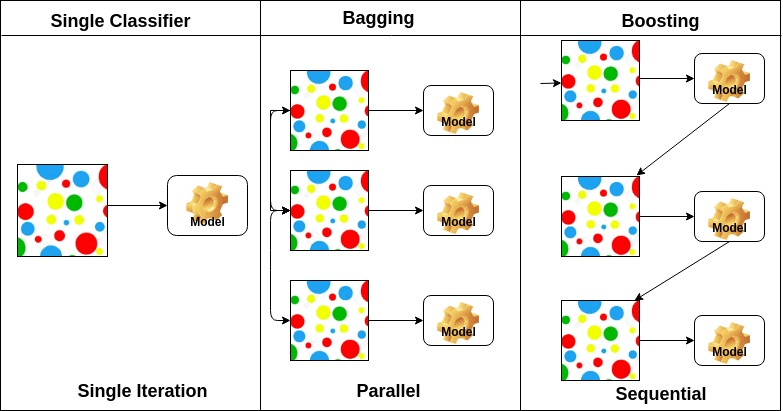

Общая идея - строим композицию последовательно, исправляя ошибки прошлых алгоритмов

Базовый алгоритм - дерево.

В качестве таргета на шаге `t` - **остатки** - разница между истинным и предсказанным значением на шаге `t-1`

Такую итеративную процедуру можно представить в виде **градиентного** спуска в функциональном пространстве - можно показать, что антиградиенты квадратичной функции потерь являются остатками -> для для каждого объекта очередной алгоритм в бустинге обучается предсказывать антиградиент функции потерь по предсказанию модели.



*Каждая формула, включенная в книгу, уменьшает число её читателей вдвое - Стивен Хокинг*

___

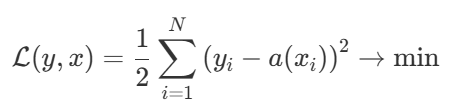

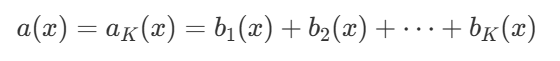

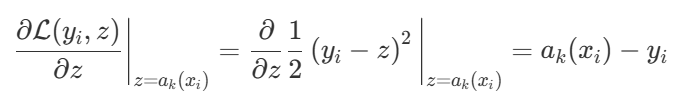

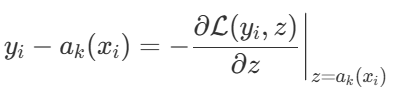

В случае использования других функций потерь, антиградиенты уже не будут остатками, поэтому их называют псевдо-остатками.

Итого, алгоритм GBM:

1. первоначальному прогнозу присваивается среднее значение y_train для всех образцов;

2. рассчитываются остатки модели на основе антиградиента функции потерь;

3. регрессионное дерево обучается на X_train и остатках, далее делается прогноз на X_train;

4. полученный прогноз добавляется к первоначальному и шаги 2-4 повторяются для каждого дерева;

5. после обучения всех моделей снова создаётся первоначальный прогноз из шага 1;

6. далее делаются прогнозы для X_test на обученных деревьях и добавляются к первоначальному;

7. полученная сумма и будет конечным прогнозом.



Таким образом, базовый алгоритм подбирается так, чтобы как можно лучше приближать антиградиент ошибки на обучающей выборке

In [28]:
model = XGBRegressor()
parameters = {
  'learning_rate': np.linspace(0.01, 1, 5),
  'max_depth': list(range(3, 10)),
  'subsample': np.linspace(0.7, 0.9, 5),
  'colsample_bytree': np.linspace(0.5, 0.98, 5),
  'n_estimators': np.arange(50, 300, 10),
  'seed': [2023]
}

xgb_random_search = RandomizedSearchCV(
    model,
    parameters,
    n_jobs=5,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=2,
    refit=True
)
xgb_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   param_distributions={'colsample_bytree': array([0.5 , 0.62, 0.74, 0.86, 0.98]),
                                        'learning_rate': array([0.01  , 0.2575, 0.505 , 0.7525, 1.    ]),
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9],
                                        'n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170,
       180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290]),
                                        'seed': [2023],
                                        'subsample': array([0.7 , 0.75, 0.8 , 0.85, 0.9 ])},
                   scoring='neg_mean_squared_error', verbose=2)

In [29]:
y_preds = xgb_random_search.best_estimator_.predict(X_test)
print(f'RMSE: {root_mean_squared_error(y_test, y_preds)}')

RMSE: 2.541655035380306


##### Настройка некоторых гиперпараметров

- Деревья чаще всего небольшие - решающие пни с высоким смещением и низкой дисперсией.
- Важен темп обучения - маленький темп способствует более хорошей тонкой оптимизации

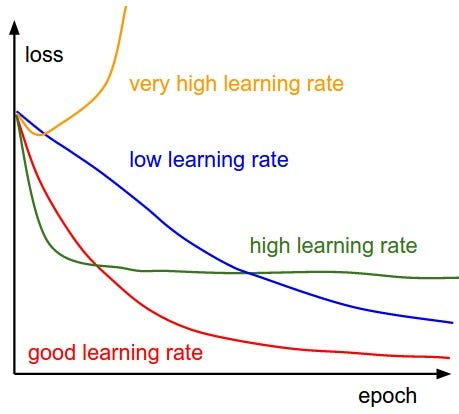

- Нет бутстрапа, но есть `subsample` - доля наблюдений для обучения - своего рода регуляризация
- В первую очередь при подборе гиперпараметров стоит найти компромисс между `learning_rate` и `iterations` - меньший темп обучения требует большего числа деревьев/итераций
- Способ обработки категориальных признаков влияет на темп обучения
- После подбора оптимального соотношения `learning_rate` и `iterations` можно подобрать гиперпараметры, определяющие структуру дерева, затем гиперпараметры, поределяющие случайность построения.
- В конце стоит снова скорректировать темп обучения.

Либо есть другой вариант:

- Случайно ищем оптимальные гиперпараметры с фиксированным небольшим числом деревьев
- Фиксируем оптимальные гиперпараметры, тюним количество деревьев



[Gradient Boosting Interactive Playground](https://arogozhnikov.github.io/2016/07/05/gradient_boosting_playground.html)

#### Другие библиотеки с градиентным бустингом...

**XGBoost**

[Документация](https://xgboost.readthedocs.io/en/stable/)


Некоторые фичи:
- Level-wise growth, затем прунинг вершин - больше устойчивость к переобучению


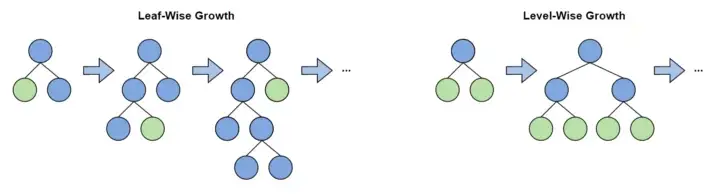

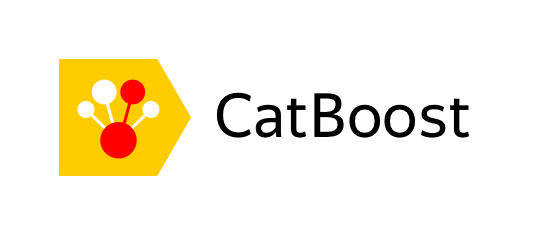

[Документация](https://catboost.ai/)

Некоторые фичи:


- Сначала выбираются параметры для разбиения, потом строится дерево - ускорение инференса и регуляризация
- Симметричные деревья для скорости
- Ordered target encoding
- Поддержка текстовых признаков



**LightGBM**

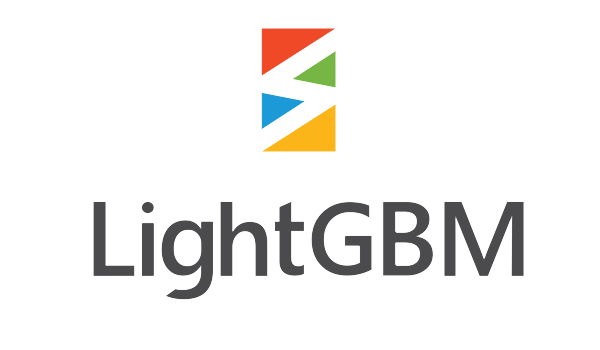

[Документация](https://lightgbm.readthedocs.io/en/latest/index.html)

Некоторые фичи:

- List-wise growth - быстрее сходится
- Обучение на всех объектах с большой ошибкой, с маленькой - сэмплируются

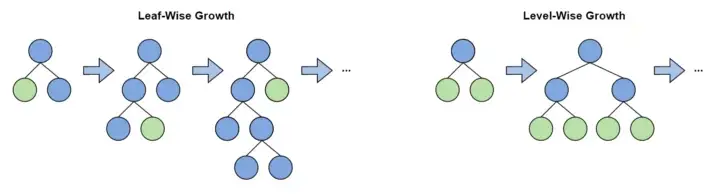

### Стэкинг

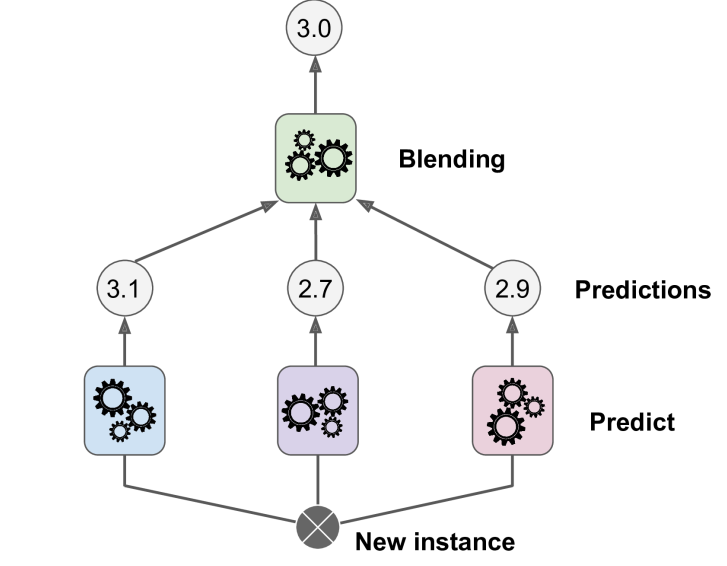

In [30]:
X_train_short, X_valid_short, y_train_short, y_valid_short = train_test_split(X_train_scaled, y_train, test_size=0.25, random_state=2023)

In [31]:
def run(model):
    model.fit(X_train_short, y_train_short)
    preds = model.predict(X_valid_short)
    print(model.__class__.__name__ + ' rmse  = ' + str(root_mean_squared_error(y_valid_short,  preds)))
    return model

In [32]:
class Stacking(BaseEstimator, RegressorMixin):
    def __init__(self, models, meta_model):
        self.models = models
        self.meta_model = meta_model
        self.n = len(models)
        self.valid = None

    def fit(self, X, y=None):
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=2023)
        self.valid = np.zeros((X_valid.shape[0], self.n))

        for i, model in enumerate(self.models):
            model.fit(X_train, y_train)
            self.valid[:, i] = model.predict(X_valid)
        self.meta_model.fit(self.valid, y_valid)
        return self

    def predict(self, X, y=None):
        X_meta = np.zeros((X.shape[0], self.n))

        for i, model in enumerate(self.models):
            X_meta[:, i] = model.predict(X)

        return self.meta_model.predict(X_meta)

In [33]:
models = [Ridge(), LinearRegression(), KNeighborsRegressor(), RandomForestRegressor(), XGBRegressor(objective='reg:squarederror')]
for model in models:
  run(model)

Ridge rmse  = 3.017151337643269
LinearRegression rmse  = 3.0191373196439364
KNeighborsRegressor rmse  = 2.780831396509676
RandomForestRegressor rmse  = 2.777113526977906
XGBRegressor rmse  = 2.874382232502308


In [34]:
%%time

meta_model = LinearRegression()

stack_model = Stacking(models, meta_model)
stack_model.fit(X_train_scaled, y_train)
preds = stack_model.predict(X_test)
print(root_mean_squared_error(y_test, preds))

2.9885631345191936
CPU times: user 1.04 s, sys: 108 ms, total: 1.14 s
Wall time: 941 ms


## Интерпретация моделей

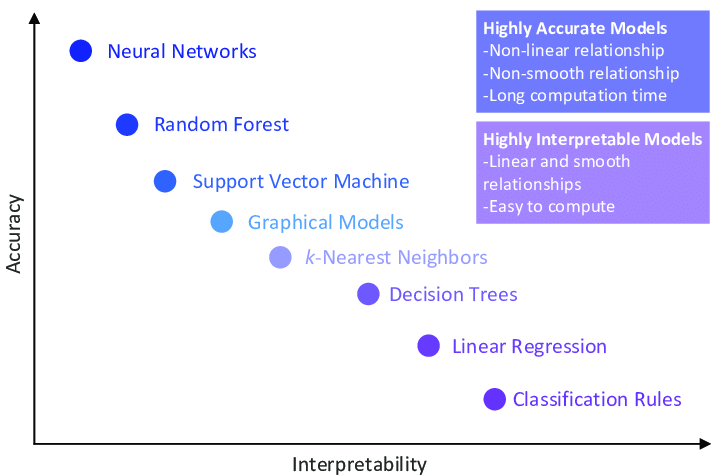

In [35]:
rf = RandomForestRegressor(random_state=2023)
rf.fit(X_train, y_train)
y_preds = rf.predict(X_test)
print(f'RMSE: {root_mean_squared_error(y_test, y_preds)}')

RMSE: 2.6341285589993437


### Mean Decrease in Impurity

- Основывается на среднем уменьшении информационного критерия при разбиении.

- Основная идея - признаки, используемые в верхней части дерева, влияют на окончательное предсказание для большей доли обучающих объектов, чем признаки, попавшие на более глубокие уровни

- Для всех правил в дереве, использующих признак, считаем уменьшение информационного критерия, суммируем, и усредняем по всем деревьям

- Если присмотреться, в этом способе числовые признаки и категориальные признаки с высокой кардинальностью ранжируются как более важные :с (почему?)

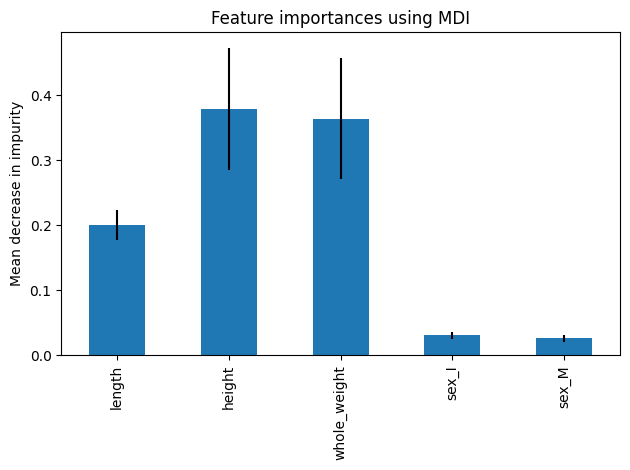

In [36]:
forest_importances = pd.Series(rf.feature_importances_, index=X_train.columns)

fig, ax = plt.subplots()
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity", )
fig.tight_layout()

### Permutation importances

Случайным образом перемешиваем данные по одному признаку за раз и смотрим на изменение целевой метрики


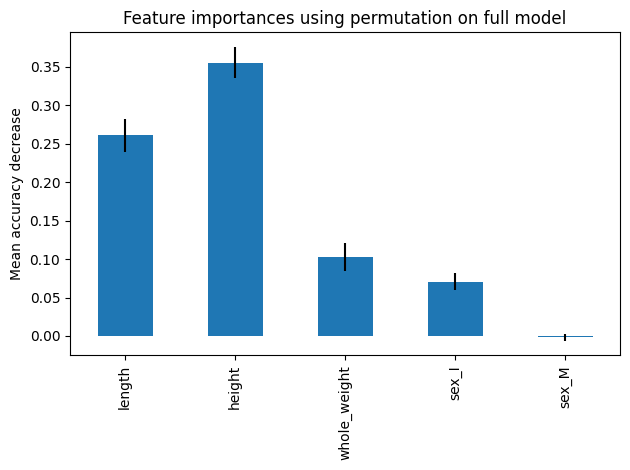

In [37]:
importances = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=2023, n_jobs=2)
forest_importances = pd.Series(importances.importances_mean, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=importances.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

### LIME

[lime - репозиторий](https://github.com/marcotcr/lime)

- Исходная **точка**, для которой требуется интерпретация, выбирается из набора данных.
- Эта точка служит центром локального анализа и основой для генерации новых, возмущенных примеров данных (бутстрап, случайный шум etc).
- Каждый возмущенный пример получает вес, основанный на его близости к исходной точке.
- Используя этот взвешенный набор данных, обучается простая интерпретируемая модель (например, линейная модель). Эта модель стремится приблизить предсказания сложной модели в локальной области, окружающей исходную точку.
- Анализируя, как меняются предсказания в ответ на возмущения, можно получить представление о том, какие факторы влияют на решения модели.


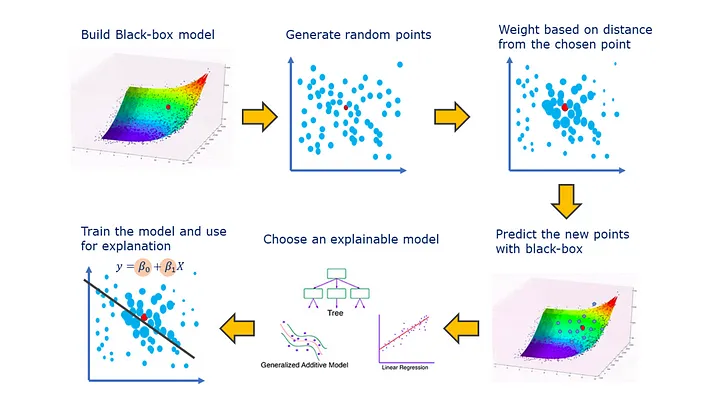

Результаты LIME являются локальными, то есть они объясняют предсказание модели для конкретного примера или наблюдения, а не для всего набора данных.

In [38]:
explainer = lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['rings'],
    verbose=True,
    mode='regression',
)
i = 33
exp = explainer.explain_instance(X_test.iloc[i].values, rf.predict, num_features=5);

Intercept 12.405437190214505
Prediction_local [7.58973163]
Right: 5.62


In [39]:
exp.show_in_notebook(show_table=True)

В случае линейной модели коэффициенты могут быть положительными или отрицательными, указывая на то, как признак влияет на предсказание (положительно или отрицательно). Величина коэффициентов указывает на степень важности признаков. Большие абсолютные значения коэффициентов свидетельствуют о большем вкладе признака в предсказание.

In [40]:
exp.as_list()

[('height <= 0.12', -2.270347398752782),
 ('whole_weight <= 0.44', -1.2642522132176282),
 ('0.00 < sex_I <= 1.00', -0.8487815141093484),
 ('length <= 0.45', -0.3761343929827821),
 ('sex_M <= 0.00', -0.05619003835449078)]

#### Проблемы?



- Генерация и взвешивание точек - узкое место

- Слабое научное обоснование

### SHAP

[Документация](https://shap.readthedocs.io/en/latest/)

Доступна локальная и глобальная интерпретация


- Создаются коалиции - подмножества всех доступных признаков в наборе данных.

- Для каждого наблюдения создаются все возможные комбинации признаков. Это включает сценарии, где некоторые признаки присутствуют, а некоторые отсутствуют.

- Для набора из N признаков, это означает создание (2^N) различных подмножеств, включая пустое множество (где отсутствуют все признаки) и полное множество (где присутствуют все признаки).

- Для каждой коалиции признаков вычисляется вклад признака, который оценивает, насколько изменяется предсказание модели при добавлении этого признака к коалиции.

- Производится перебор всех возможных коалиций признаков, и для каждой из них вычисляется, как изменится предсказание модели при добавлении рассматриваемого признака.

- Вычисляется среднее взвешенное влияние признака на предсказание модели, учитывая все возможные коалиции. Это среднее и является значением Шепли для данного признака.

- Значения Шепли для всех признаков суммируются для каждого наблюдения, чтобы оценить их коллективный вклад в предсказание модели.

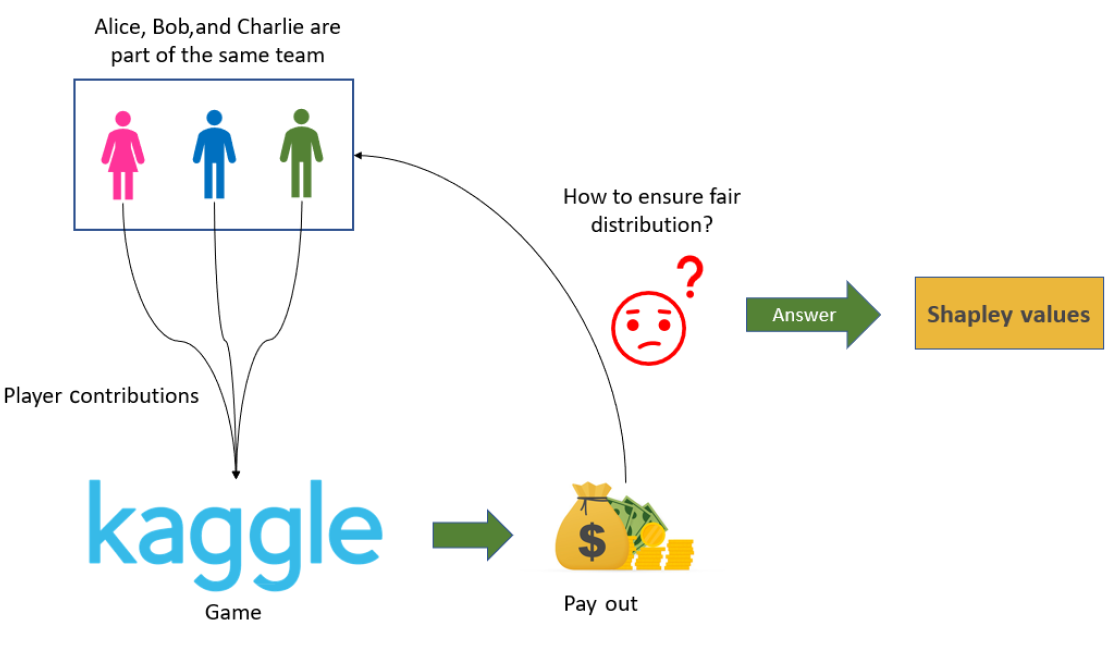

In [41]:
explainer = shap.TreeExplainer(rf)

In [44]:
choosen_instance = X_test.iloc[[33]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

In [45]:
choosen_instance = X_test.iloc[[10]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

In [50]:
choosen_instance = X_test_scaled.iloc[[20]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

Summary plot

- Каждая горизонтальная линия соответствует одному признаку
- Отдельные точки соответствуют тестовым примерам
- Кордината точки по X - SHAP value
- Цвет точки - значение признака

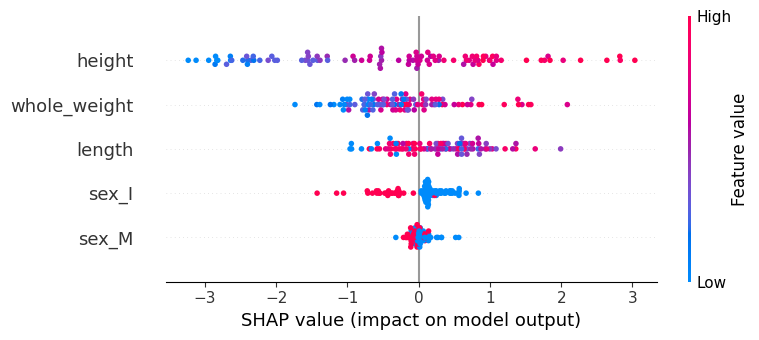

In [51]:
shap_values = explainer.shap_values(X_train.iloc[:100])
shap.summary_plot(shap_values, X_train.iloc[:100])

#### Проблемы?



- Высокая вычислительная сложность, используются аппроксимации
- При небольшой исходной выборке лучше использовать не обобщающий SHAP-подход, а локальный метод LIME
